# Dermatologist AI
## Skin Lesion Analysis Towards Melanoma Detection

### Lesion Classification
#### Phase 1: Details and Training Data

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
#import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_dir = 'data/train'
valid_dir = 'data/valid'
test_dir = 'data/test'

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [5]:
trainset = datasets.ImageFolder(train_dir, transform=transform)
validset = datasets.ImageFolder(valid_dir, transform=transform)
testset = datasets.ImageFolder(test_dir, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [5]:
label_title = ["melanoma", "nevus", "seborrheic_keratosis"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

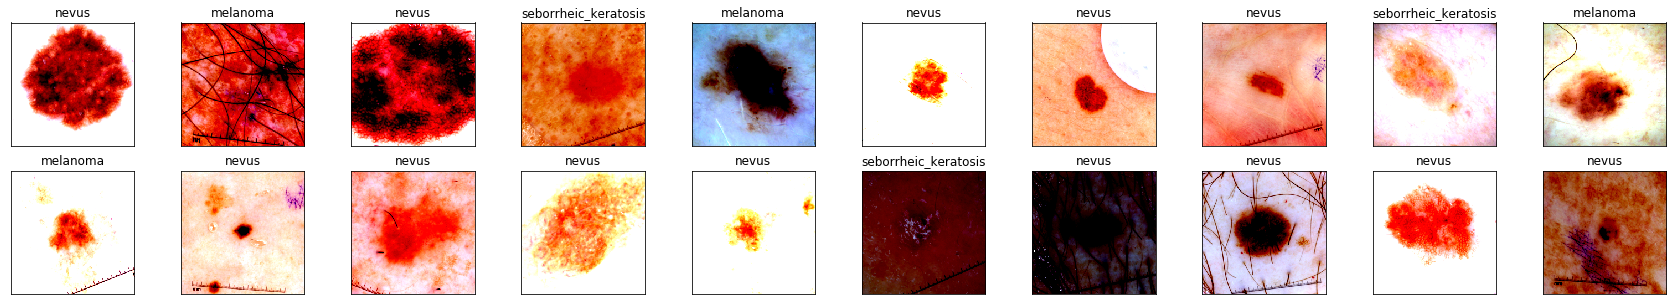

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(30, 5))
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(label_title[labels[i].item()])

#### Phase 2: Validation Submission-Training and Validation Phase

In [ ]:
model = torchvision.models.densenet201(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /home/oywa/.cache/torch/checkpoints/densenet201-c1103571.pth
61.8%

In [7]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [8]:
for param in model.features.parameters():
    param.requires_grad = False
    
in_feat = model.classifier.in_features
model.classifier = torch.nn.Linear(in_feat, 3)

model.classifier

Linear(in_features=1920, out_features=3, bias=True)

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.01)

In [ ]:
epochs = 5
valid_inf = np.Inf

for epoch in range(1, epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += train_loss
    
    model.eval()
    for batch_idx, (data, target) in enumerate(validloader):
        
        output = model.forward(data)
        loss = criterion(output, target)
        valid_loss += valid_loss
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
    
    if valid_loss <= valid_inf:
        torch.save(model.state_dict(), 'scmodel.pt')
        valid_inf = valid_loss

Epoch: 1 	Training Loss: 0.000000 	Validation Loss: 0.000000


In [13]:
model.load_state_dict(torch.load('scmodel.pt', map_location='cpu'))

<All keys matched successfully>

In [11]:
test_loss = 0.0
correct = 0.0
total = 0.0

model.eval()
for batch_idx, (data, target) in enumerate(testloader):
    
    output = model.forward(data)
    loss = criterion(output, target)
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    pred = output.data.max(1, keepdim=True)[1]
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)
            
print('Test Loss: {:.6f}\n'.format(test_loss))
print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

Test Loss: 5.820127


Test Accuracy: 22% (77/347)


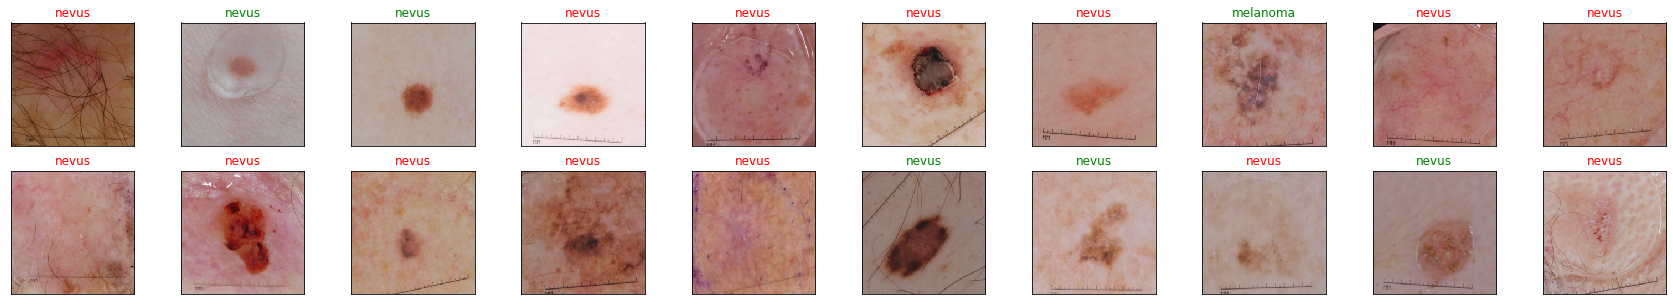

In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

out = model.forward(images)
prediction = out.data.max(1)[1]

fig = plt.figure(figsize=(30, 5))
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    if prediction[i].item() == labels[i].item():
        ax.set_title(label_title[prediction[i].item()], color='g')
    else:
        ax.set_title(label_title[prediction[i].item()], color='r')